[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/talmolab/dreem/blob/docs/examples/dreem-demo.ipynb)

# End-to-end demo

This notebook will walk you through the DREEM pipeline end to end, from obtaining data to training a model, evaluating on a held-out dataset, and visualizing the results. Here, we'll use the API, but we also provide a CLI interface for convenience.

To run this demo, we have provided sample data and configurations. The data used in this demo is small enough to be run on a single machine, though a GPU is recommended. 

#### Install DREEM and dependencies (Colab only)


In [ ]:
# Install uv (fast Python package installer)
%pip install uv

# Install dreem and dependencies using uv
!uv pip install dreem-track huggingface_hub opencv-python-headless

# Install ffmpeg for video export (Colab-specific)
!apt-get install -y ffmpeg

In [76]:
import torch
import pandas as pd
import numpy as np
import os
import glob
import imageio
import yaml
from pathlib import Path
from datetime import datetime
import pytorch_lightning as pl
import sleap_io as sio
import matplotlib.pyplot as plt
import h5py

Check if a GPU is available. For Apple silicon users, you can run on MPS, but ensure your version of PyTorch is compatible with MPS, and that you have installed the correct version of DREEM. You can also run without a GPU. The demo has been tested on an M3 Macbook Air running only on a CPU.


In [77]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    accelerator = "mps"
    devices = 1
else:
    accelerator = "cpu"
print("Using device: ", accelerator)

torch.set_float32_matmul_precision("medium")

CUDA available: False
Using device:  mps


## Download data and configs

In [ ]:
!hf download talmolab/sample-flies --repo-type dataset --local-dir ./data

## Training

We just need to specify the data paths and the crop size to train the model. The crop size is the size (in pixels) of the square box we make around the instance. It should be of the order of the size of the instance.

Lets figure out an appropriate crop size. We can do this by loading a frame and experimenting with different sizes. For this data, a crop size of 128 seems appropriate.

In [78]:
crop_size = 128  # Adjust this to see what the bounding box looks like

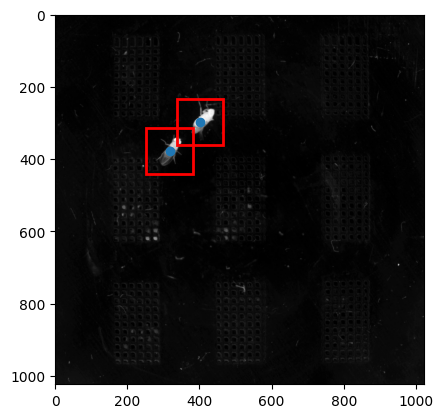

In [74]:
slp_files = glob.glob("./data/train/*.slp")
video_files = glob.glob("./data/train/*.mp4")
labels = sio.load_slp(slp_files[0])
video = imageio.get_reader(video_files[0])
frame = video.get_data(0)
centers = []
for instance in labels[0].instances:
    centers.append(np.nanmean(instance.numpy(), axis=0))
centers = np.array(centers)
plt.imshow(frame)
plt.scatter(centers[:, 0], centers[:, 1])
# Draw a square box centered at each centroid with a given crop size (e.g., 128)
for cx, cy in centers:
    top_left = (int(cx - crop_size // 2), int(cy - crop_size // 2))
    rect = plt.Rectangle(top_left, crop_size, crop_size, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()

### That's it! Now we can train the model

In [79]:
!dreem train ./data/train --val-dir ./data/val --crop-size {crop_size}

Configuration saved to: logs/config.dreem_train.01-13-2026-22-15-05.yaml
╭──────────────────────────── Train Configuration ─────────────────────────────╮
╰──────────────────────────────────────────────────────────────────────────────╯
Starting training...
None not one of ['CSVLogger', 'TensorBoardLogger', 'WandbLogger'] or set to None, skipping logging
┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type                      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ GlobalTrackingTransformer │ 11.5 M │ train │     0 │
│ 1 │ loss  │ AssoLoss                  │      0 │ train │     0 │
└───┴───────┴───────────────────────────┴────────┴───────┴───────┘
Trainable params: 11.5 M                                                        
Non-trainable params: 0                                                         
Total params: 11.5 M                                                            


## Tracking
Here we run tracking on a video with **no** ground truth labels using the model we just trained. Note that we're using a command line argument to set the maximum number of tracks to 2 since its a 2 flies dataset. You can run the help command below to see all the options.

In [80]:
!dreem track --help

                                                                                
 Usage: dreem track [OPTIONS] INPUT_PATH                                        
                                                                                
 Run tracking on a dataset.                                                     
                                                                                
╭─ Arguments ──────────────────────────────────────────────────────────────────╮
│ *    input_path      PATH  Input data directory [required]                   │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ *  --checkpoint           -ckpt              PATH     Model checkpoint path  │
│                                                       [required]             │
│ *  --output               -o                 PATH     Output directory       │
│                           

In [82]:
models_dir = "./models/dreem_train"
ckpt_files = glob.glob(os.path.join(models_dir, "*final*.ckpt"))
final_ckpt = ckpt_files[0]  # Pick the first one found
print(f"Using checkpoint: {final_ckpt}")

Using checkpoint: ./models/dreem_train/epoch=4-final-val_loss=0.16654770076274872.ckpt


In [83]:
!dreem track ./data/inference --checkpoint {final_ckpt} --output ./results --crop-size {crop_size} --max-tracks 2 

Configuration saved to: results/config.track.01-13-2026-22-28-50.yaml
╭──────────────────────────── Track Configuration ─────────────────────────────╮
│ Checkpoint:  models/dreem_train/epoch=4-final-val_loss=0.16654770076274872.… │
│ Output:      results                                                         │
│ Input:       data/inference                                                  │
╰──────────────────────────────────────────────────────────────────────────────╯
Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80/80 0:03:29 • 0:00:00 0.37it/s it/s it/s 
Saving .slp and frame metadata: 100%|█████████| 80/80 [00:00<00:00, 1195.62it/s]
Results saved to results


## Evaluate the tracking results
### Here we run inference on a video **with** ground truth labels. Then we will compute metrics for our tracking results. 
Note that we are only using separate configs for inference and evaluation so you can verify that the test file has no ground truth in it for inference, and that it does for evaluation. For eval, the slp file should have a "GT_" prefix to indicate that it is a ground truth file. For eval, you can also specify the metrics you want to compute. We offer a CLI interface for both evaluation and inference.

### Advanced Usage
Some advanced training parameters cannot be set through CLI overrides, particularly for training parameters. This section demonstrates the use of configuration files to achieve fine grained control over all training parameters that Pytorch Lightning offers.

#### Setup configuration file
Here we override the default training parameters to use different augmentations, minimum epochs, and optimizer parameters. You can edit these directly in the config file at the path below. Try out some of your own augmentations! We use [Albumentations](https://albumentations.ai/) for augmentations.

In [ ]:
train_config_path = "./data/configs/base.yaml"
with open(train_config_path, "r") as f:
    config_yaml = yaml.safe_load(f)
print(yaml.dump(config_yaml, default_flow_style=False))

YAML config contents:
dataset:
  train_dataset:
    anchors: centroid
    augmentations:
      GaussianBlur:
        blur_limit:
        - 3
        - 7
        p: 0.2
        sigma_limit: 0
      MotionBlur:
        blur_limit:
        - 3
        - 7
        p: 0.2
      RandomBrightnessContrast:
        brightness_limit: 0.1
        contrast_limit: 0.3
        p: 0.3
      Rotate:
        limit: 45
        p: 0.3
    clip_length: 32
    crop_size: 128
    dir:
      labels_suffix: .slp
      path: ./data/train
      vid_suffix: .mp4
    padding: 0
logging:
  logger_type: null
  name: example_train
optimizer:
  betas:
  - 0.9
  - 0.999
  eps: 1e-8
  lr: 0.0001
  name: Adam
  weight_decay: 0.01
trainer:
  max_epochs: 3
  min_epochs: 1



### Train the model with configs

In [ ]:
!dreem train ./data/train --val-dir ./data/val --crop-size {crop_size} --config ./data/configs/base.yaml

### Run inference with configs

If you want to run tracking with more parameters, it can sometimes be easier to use a config file. Here we use the inference config file. Here, we use max_center_dist, which limits how far each instance is allowed to be frame over frame in order to be considered the same instance, and a confidence threshold to flag low confidence predictions. 

In [84]:
track_config_path = "./data/configs/inference.yaml"
with open(track_config_path, "r") as f:
    config_yaml = yaml.safe_load(f)
print(yaml.dump(config_yaml, default_flow_style=False))

ckpt_path: null
dataset:
  test_dataset:
    anchors: centroid
    clip_length: 32
    dir:
      labels_suffix: .slp
      path: ./data/inference
      vid_suffix: .mp4
outdir: ./inference
tracker:
  iou: mult
  max_center_dist: 80
  max_tracks: 2
  overlap_thresh: 0.01



In [ ]:
!dreem track ./data/inference --checkpoint {final_ckpt} --output ./results --crop-size {crop_size} --config ./data/configs/inference.yaml

#### Visualize the input data
The input data to the model is a set of crops taken around a particular keypoint on the instance. For animals, this can be any keypoint, and for microscopy, this is often the centroid. Augmentations are also applied. Since we shuffle the data, the frame ids you get may not be the first frames of the video.

In [ ]:
from dreem.io import Config
from omegaconf import DictConfig

with open("/Users/mustafashaikh/dreem-cli-refactor/dreem/configs/defaults/train.yaml", "r") as f:
    cfg = DictConfig(yaml.safe_load(f))
train_cfg = Config(cfg)
train_dataset = train_cfg.get_dataset(mode="train")
train_dataloader = train_cfg.get_dataloader(train_dataset, mode="train")

In [64]:
# load a batch of data in
viewer = iter(train_dataloader)
batch = next(viewer)
# save the crops for all frames in the batch
crops = {}
for frame in batch[0]:
    crops[frame.frame_id.item()] = []
    for instance in frame.instances:
        crops[frame.frame_id.item()].append(
            instance.crop.squeeze().permute(1, 2, 0).numpy()
        )

Plot the crops for all frames in the batch

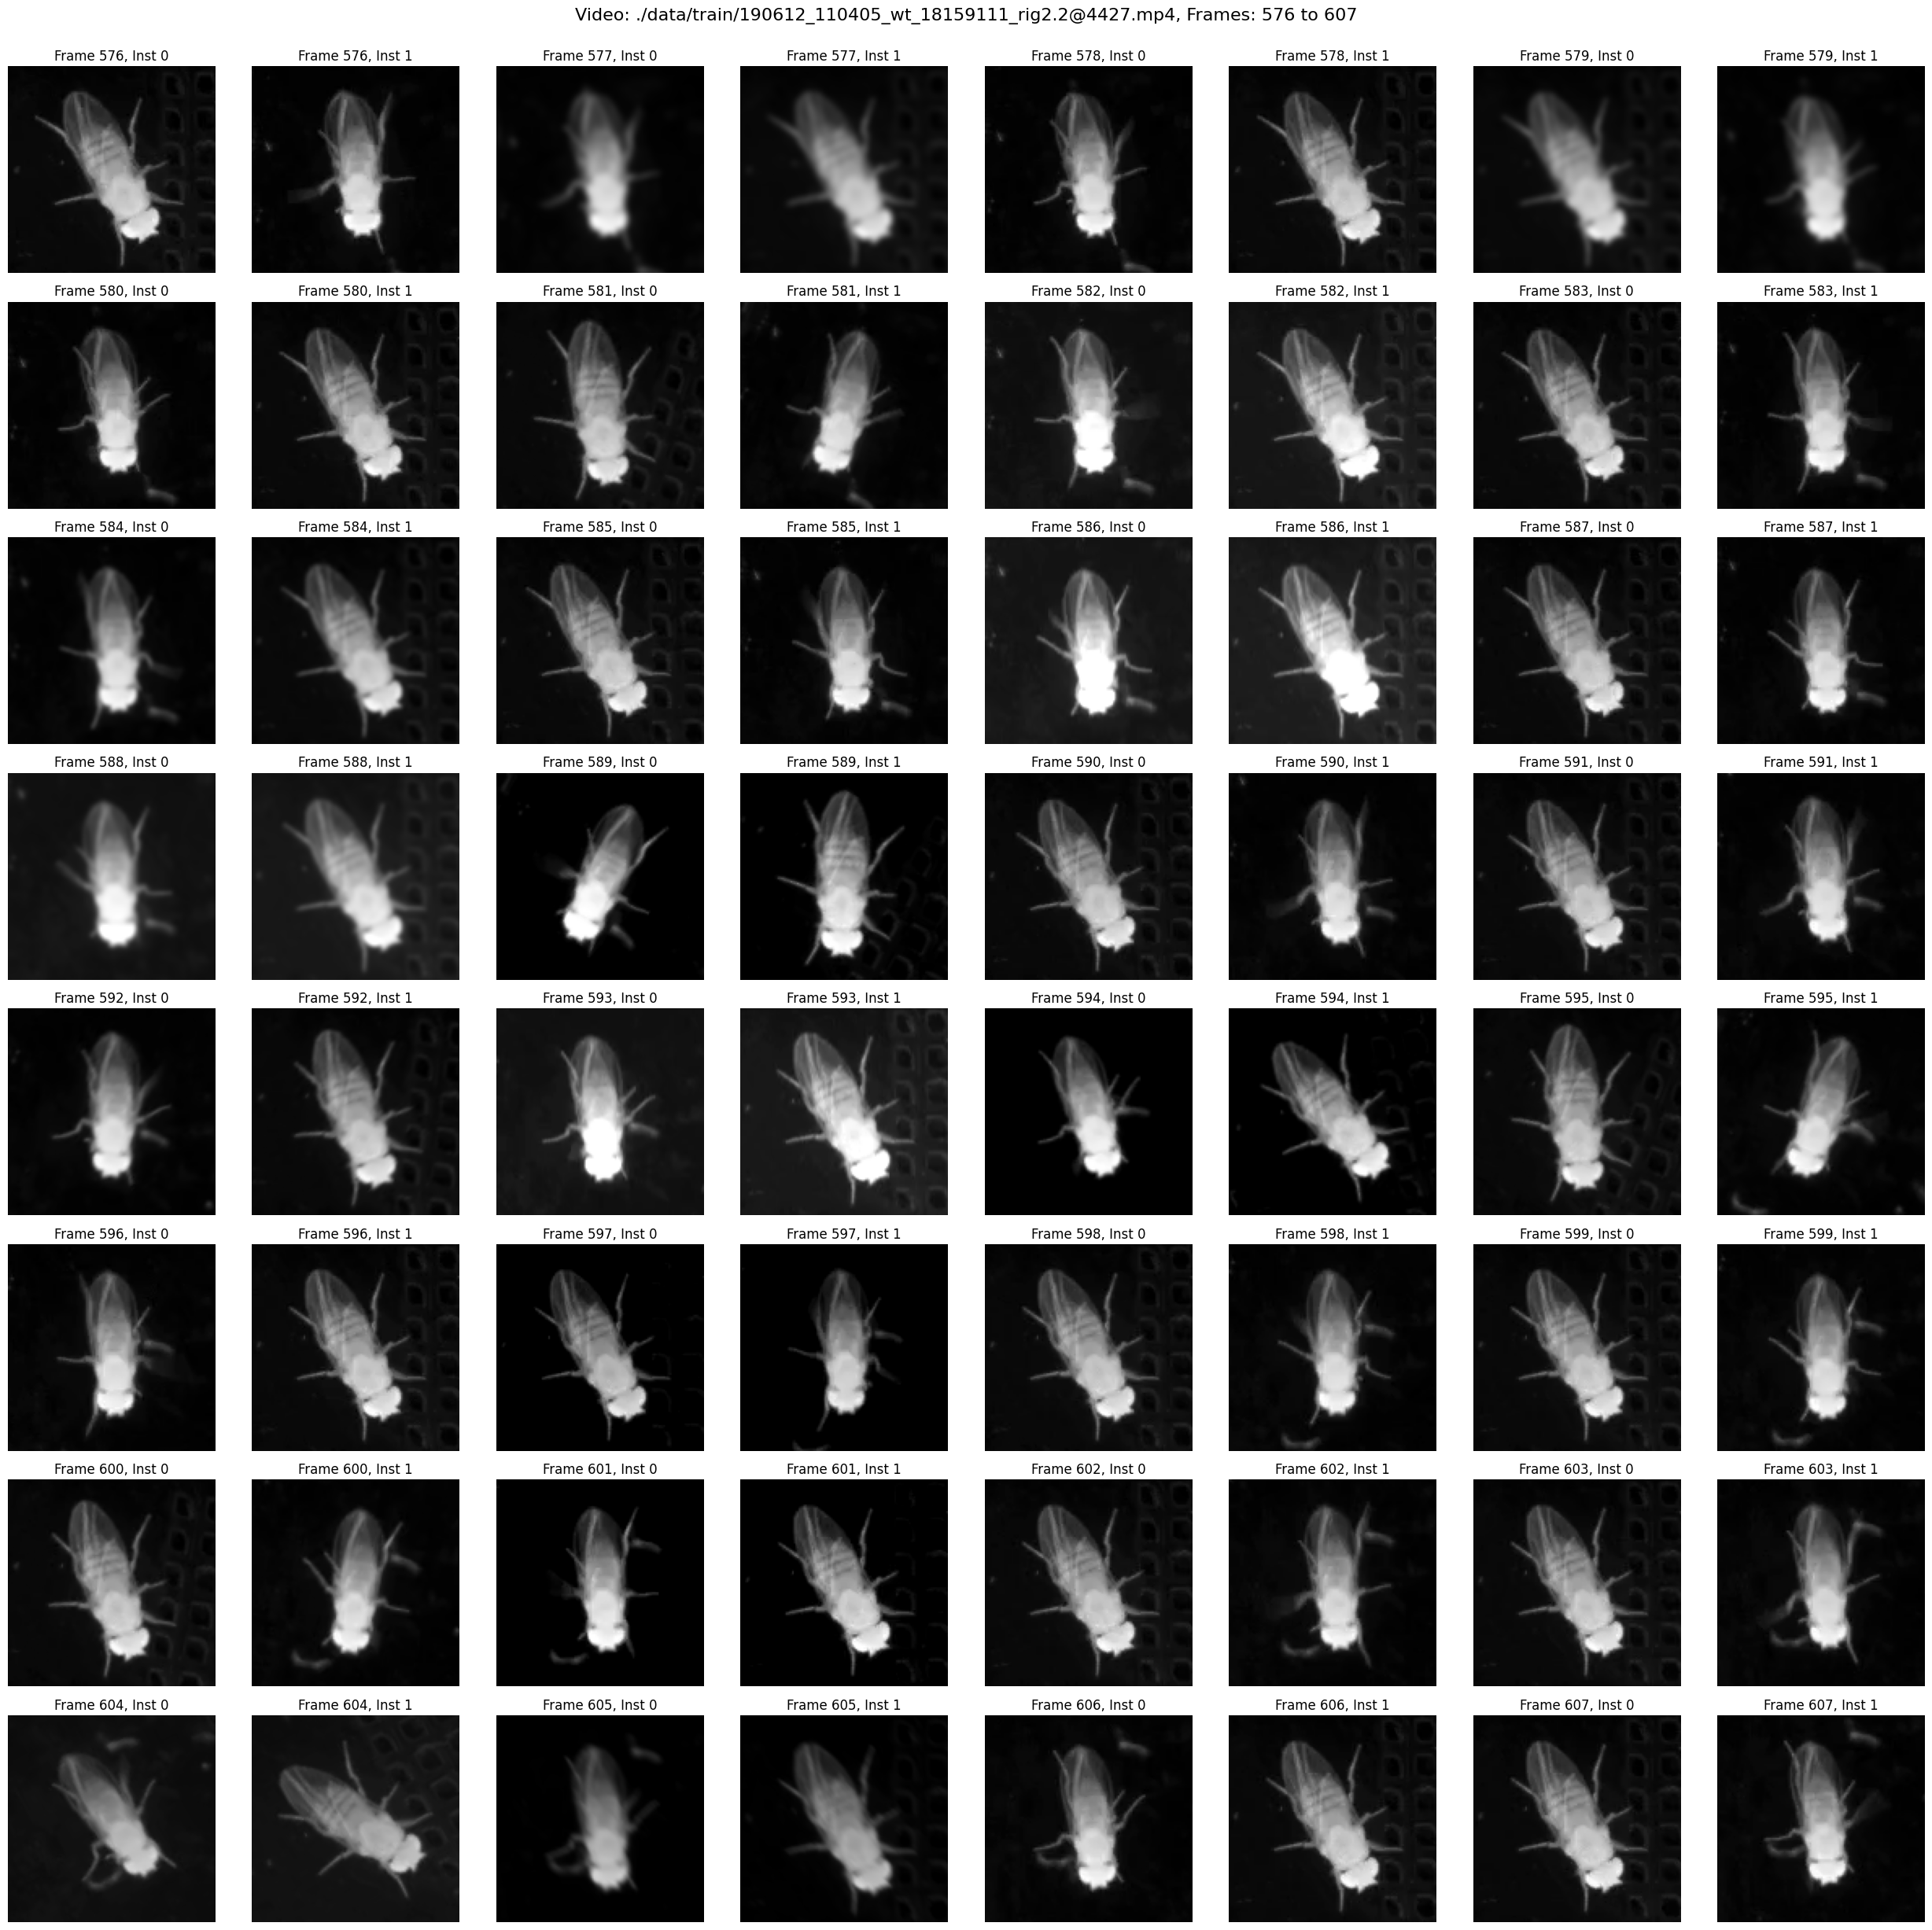

In [65]:
total_crops = sum(len(crops) for crops in crops.items())

# Determine a grid size
n_cols = int(np.ceil(np.sqrt(total_crops)))
n_rows = int(np.ceil(total_crops / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))
fig.suptitle(
    f"Video: {frame.video}, Frames: {min(crops.keys())} to {max(crops.keys())}",
    fontsize=16,
)

# Ensure axes is always a 2D array
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten for easier indexing
axes_flat = axes.flatten()

# Plot each crop
ax_idx = 0
for frame_id, vid_crops in sorted(crops.items()):
    for i, crop in enumerate(vid_crops):
        if ax_idx < len(axes_flat):
            ax = axes_flat[ax_idx]

            # Handle both RGB and grayscale images
            if crop.ndim == 3:
                # Normalize if needed
                if crop.max() > 1.0:
                    crop = crop / 255.0
                ax.imshow(crop)
            else:
                ax.imshow(crop, cmap="gray")

            ax.set_title(f"Frame {frame_id}, Inst {i}")
            ax.axis("off")
            ax_idx += 1

# Hide unused subplots
for i in range(ax_idx, len(axes_flat)):
    axes_flat[i].axis("off")

# Adjust layout to minimize whitespace
plt.tight_layout()
plt.subplots_adjust(top=0.95)

## Visualize the results

In [20]:
import cv2
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import matplotlib.cm as cm
from IPython.display import HTML, display
import io
import base64
from IPython.display import Video


def create_animal_tracking_animation_notebook(
    video_path,
    metadata_df,
    fps=30,
    text_size=8,
    marker_size=20,
    max_frames=None,
    display_width=800,
):
    """
    Create and display an animal tracking animation directly in the notebook.

    Parameters:
    -----------
    video_path : str
        Path to the input MP4 video file
    metadata_df : pandas.DataFrame
        DataFrame with columns: frame_id, track_id, centroid
    fps : int
        Frames per second for the animation
    text_size : int
        Size of the ID text
    marker_size : int
        Size of the marker circle
    max_frames : int, optional
        Maximum number of frames to process (useful for previewing)
    display_width : int
        Width of the displayed animation in the notebook
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create a colormap for track IDs
    unique_ids = metadata_df["track_id"].unique()
    cmap = cm.get_cmap(
        "tab10", len(unique_ids)
    )  # Using 'hsv' for bright, distinct colors
    id_to_color = {id_val: cmap(i) for i, id_val in enumerate(unique_ids)}

    # Set up the figure and axis with the correct aspect ratio
    fig_width = display_width / 100  # Convert to inches (assuming 100 dpi)
    fig_height = fig_width * (height / width)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Initialize the plot elements
    frame_img = ax.imshow(np.zeros((height, width, 3), dtype=np.uint8))
    markers = []
    texts = []

    # Get the list of frame IDs from the metadata
    frame_ids = sorted(metadata_df["frame_id"].unique())

    # Limit the number of frames if specified
    if max_frames is not None and max_frames < len(frame_ids):
        frame_ids = frame_ids[:max_frames]
        print(f"Limiting preview to {max_frames} frames")

    # Function to update the animation for each frame
    def update(frame_num):
        # Read the frame from the video
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame {frame_num}")
            return []

        # Convert BGR to RGB (OpenCV uses BGR, matplotlib uses RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_img.set_array(frame_rgb)

        # Clear previous markers and texts
        for marker in markers:
            marker.remove()
        markers.clear()

        for text in texts:
            text.remove()
        texts.clear()

        # Get data for the current frame
        frame_data = metadata_df[metadata_df["frame_id"] == frame_num]

        # Add markers and IDs for each animal in the current frame
        for _, row in frame_data.iterrows():
            track_id = row["track_id"]
            x, y = row["centroid"]
            color = id_to_color[track_id]

            # Add circle marker
            circle = Circle((x, y), marker_size, color=color, alpha=0.7)
            markers.append(ax.add_patch(circle))

            # Add ID text
            text = ax.text(
                x,
                y,
                str(track_id),
                color="white",
                fontsize=text_size,
                ha="center",
                va="center",
                fontweight="bold",
            )
            texts.append(text)

        # Add frame number for reference
        frame_text = ax.text(
            10,
            20,
            f"Frame: {frame_num}",
            color="white",
            fontsize=text_size,
            backgroundcolor="black",
        )
        texts.append(frame_text)

        return [frame_img] + markers + texts

    # Set up the axis
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Invert y-axis to match image coordinates
    ax.axis("off")

    # Create the animation
    print(f"Creating animation with {len(frame_ids)} frames...")
    anim = FuncAnimation(fig, update, frames=frame_ids, blit=True)

    # Display the animation in the notebook
    plt.close(fig)  # Prevent duplicate display

    # Display as HTML5 video
    html_video = HTML(anim.to_html5_video())
    display(html_video)

    return anim


# Option to save the animation to a file for later viewing
def save_animation(anim, output_path, fps=10, dpi=100):
    """Save the animation to a file"""
    anim.save(output_path, writer="ffmpeg", fps=fps, dpi=dpi)
    print(f"Animation saved to {output_path}")

    # Display the saved video in the notebook
    return Video(output_path, embed=True, width=800)

Load the predictions into a dataframe to make an animation

In [21]:
list_frames = []
for lf in pred_slp:
    for instance in lf.instances:
        centroid = np.nanmean(instance.numpy(), axis=0)
        track_id = int(instance.track.name)
        list_frames.append(
            {"frame_id": lf.frame_idx, "track_id": track_id, "centroid": centroid}
        )
df = pd.DataFrame(list_frames)

Create and display the animation in the notebook

In [ ]:
for file in os.listdir(pred_cfg.cfg.dataset.test_dataset["dir"]["path"]):
    if file.endswith(".mp4"):
        video_path = os.path.join(
            pred_cfg.cfg.dataset.test_dataset["dir"]["path"], file
        )

anim = create_animal_tracking_animation_notebook(
    video_path=video_path,
    metadata_df=df,
    fps=15,
    text_size=8,
    marker_size=20,
    max_frames=300,
)

# save the animation
video = save_animation(anim, f"./animal_tracking_vis-{video_path.split('/')[-1]}")

### Extract the results and view key metrics
Multi-object tracking metrics are saved to a csv file in the selected output directory.

In [ ]:
motmetrics = list(dict_vid_motmetrics.values())[0]
# motmetrics.loc[motmetrics['metric'] == 'num_switches']
motmetrics